<a href="https://colab.research.google.com/github/mahesh-ishran/Object-Detection/blob/main/Selective%20Search%20for%20region%20proposal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install selectivesearch -q

In [3]:
import selectivesearch
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import skimage.data
import numpy as np

This function uses the `selectivesearch` library to identify potential object locations in an image. It then draws these proposed bounding boxes on the original image and displays the result using Matplotlib.


**skimage :**
In the code provided, the `skimage` library (specifically `skimage.data`) is used to load sample images for demonstration purposes. It provides built-in datasets like the 'astronaut' and 'chelsea' images, which are convenient for testing the `perform_selective_search` function without needing to provide an external image file.

**cv2 :** In the provided code, the `cv2` library (OpenCV) is used for image processing tasks. Specifically, it's used for converting the color space of the image from RGB to BGR and vice-versa using `cv2.cvtColor()`. This is necessary because selectivesearch works best in RGB, while OpenCV's default is BGR.

##**...................using `selectivesearch` for selective search for region of interest....................**

In [4]:
# Use a sample image
img_rgb = skimage.data.astronaut()
img = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [5]:
img_rgb.shape

(512, 512, 3)

In [6]:
# Perform selective search with some parameters
img_lbl, regions = selectivesearch.selective_search(
    img_rgb, scale=500, sigma=0.9, min_size=10
)

/usr/local/lib/python3.11/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


The output of `selectivesearch.selective_search(img_rgb, scale=500, sigma=0.9, min_size=10)` consists of two main components:

1.  **`img_lbl`**: This is a labeled image where each pixel is assigned an integer value representing the segment or region it belongs to. Pixels within the same region will have the same label. This output is useful for visualizing the initial segmentation of the image before region proposals are generated.

2.  **`regions`**: This is a list of dictionaries. Each dictionary represents a potential object region (a bounding box) found by the selective search algorithm. The dictionary for each region typically contains:
    *   `'rect'`: A tuple `(x, y, w, h)` representing the bounding box coordinates. `x` and `y` are the top-left corner coordinates, `w` is the width, and `h` is the height.
    *   `'size'`: The size (number of pixels) of the region.
    *   Other potential keys might include `'labels'` (the labels of the segments merged to form this region) and `'misc'` (miscellaneous information).

Now, let's talk about the parameters:

*   **`scale`**: This parameter controls the scale of the segmentation. A larger `scale` value will result in larger initial regions and fewer region proposals. It influences how aggressively adjacent regions are merged in the initial segmentation step.
*   **`sigma`**: This parameter is related to the smoothing of the image before the segmentation. A higher `sigma` value applies more smoothing, which can help in grouping together similar neighboring pixels and reducing the impact of noise.

The **`sigma`** parameter in `selectivesearch` is used for Gaussian smoothing of the image before the segmentation step.

<u>Smoothing</u>
<br>Smoothing is a process that reduces noise and detail in an image by averaging the pixel values within a local neighborhood. Gaussian smoothing uses a Gaussian function (a bell-shaped curve) to determine the weights of the pixels in the neighborhood. Pixels closer to the center of the neighborhood have a higher weight, while those further away have a lower weight.

<u>In the context of selectivesearch:</u>
<br>A higher sigma value means more smoothing is applied.
<br>More smoothing leads to larger, more homogeneous initial regions.
<br>This can be helpful in reducing the impact of small textures or noise, leading to fewer, but potentially more meaningful, initial segments.
<br>It influences how the initial segmentation is performed, which in turn affects the subsequent merging process and the final region proposals.

Essentially, sigma helps to simplify the image data by blurring it slightly, making it easier for the algorithm to group similar pixels together into initial regions.

*   **`min_size`**: This parameter sets the minimum size (number of pixels) for a region to be considered in the initial segmentation. Regions smaller than `min_size` are likely to be merged with neighboring regions. This helps to filter out very small and potentially noisy segments.

In summary, `selectivesearch.selective_search` performs hierarchical grouping of pixels to propose a set of bounding boxes that are likely to contain objects. The `scale`, `sigma`, and `min_size` parameters allow you to control the granularity and characteristics of these proposed regions.

In [7]:
print('total regions : ',len(regions))
print(img_lbl.shape)

total regions :  570
(512, 512, 4)


Output of selectivesearch.selective_search:

img_lbl is a $512$ x $512$ dimensional array. Each inner list [R, G, B, Label] represents a pixel, where the first three values are the R, G, and B color components of the pixel, and the last value is the integer label assigned to that pixel's segment.

In [8]:
# Filter duplicate and small regions and invalid regions(regions with zero width or hight)
candidates = set()
for r in regions:
    if r['rect'] in candidates:
        continue
    if r['size'] < 200:
        continue
    x, y, w, h = r['rect']
    if w == 0 or h == 0:
        continue
    candidates.add(r['rect'])

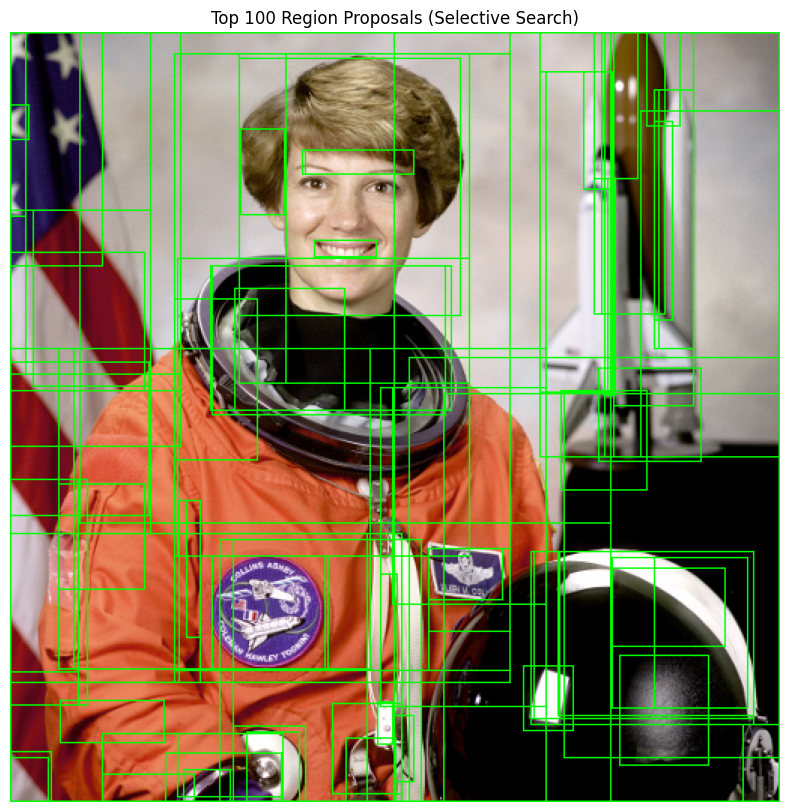

In [9]:
# Draw top N regions
output = img_rgb.copy()
for i, (x, y, w, h) in enumerate(list(candidates)[:100]):
    cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 1)

# Display
plt.figure(figsize=(10, 10))
plt.imshow(output)
plt.title("Top 100 Region Proposals (Selective Search)")
plt.axis("off")
plt.show()

##............**naive approach for selective search for regions of interest**..........

In [10]:
 # Load image
img = skimage.data.astronaut()
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_h, img_w = img.shape[:2]
print(img.shape)
print(img_h,img_w)

(512, 512, 3)
512 512


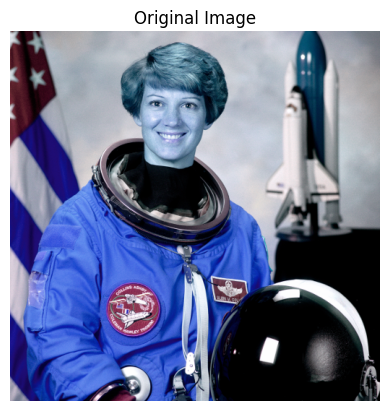

In [11]:
plt.imshow(img_rgb)
plt.title("Original Image")
plt.axis('off')
plt.show()

###**1. Initial Segmentation: Simple Grid**

We divide the image into fixed-size blocks (e.g., 50x50) instead of smart segmentation.

In [12]:
# Segment the image into non-overlapping fixed-size blocks
block_size = 50
regions = []

for y in range(0, img_h, block_size):
    for x in range(0, img_w, block_size):
        w = min(block_size, img_w - x)
        h = min(block_size, img_h - y)
        # print(y,x,w,h)
        roi = img_rgb[y:y+h, x:x+w]
        avg_color = roi.mean(axis=(0,1))  # average RGB
        regions.append({
            'rect': (x, y, w, h),
            'color': avg_color,
            'size': w * h
        })
print('last block coordinates : ',y,x,w,h)
print('last block dimensions : ',roi.shape)
print(avg_color.shape)
print('average of each color in last block : ',avg_color)
print('total blocks made out of image : ',len(regions))

last block coordinates :  500 500 12 12
last block dimensions :  (12, 12, 3)
(3,)
average of each color in last block :  [43.39583333 46.31944444 49.43055556]
total blocks made out of image :  121


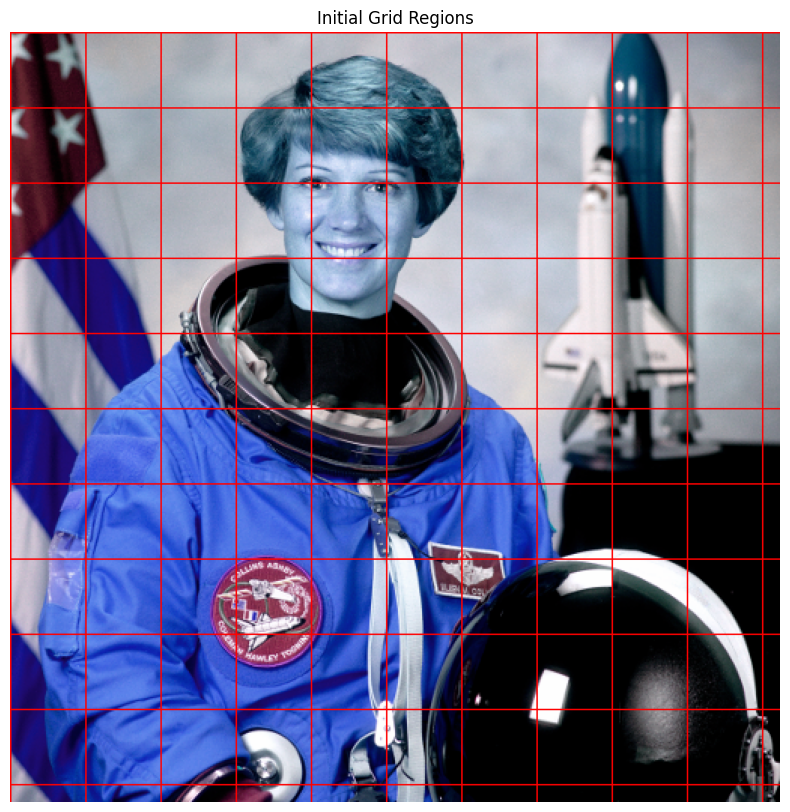

In [13]:
# Draw initial grid regions
output_initial = img_rgb.copy()

for r in regions:
    x, y, w, h = r['rect']
    cv2.rectangle(output_initial, (x, y), (x + w, y + h), (255, 0, 0), 1) # Use a different color for initial regions

plt.figure(figsize=(10, 10))
plt.imshow(output_initial)
plt.title("Initial Grid Regions")
plt.axis('off')
plt.show()

**`cv2.rectangle(output_initial, (x, y), (x + w, y + h), (255, 0, 0), 1)`**:

**`cv2.rectangle()`** : This is a function from the OpenCV library (cv2) used to draw a rectangle on an image.

**`output_initial`** : This is the image on which the rectangle will be drawn. In this case, it's a copy of your original image (img_rgb) that you created to avoid drawing on the original data directly.

**`(x, y)`** : This tuple represents the coordinates of the top-left corner of the rectangle. x is the horizontal coordinate (column) and y is the vertical coordinate (row).

**`(x + w, y + h)`** : This tuple represents the coordinates of the bottom-right corner of the rectangle. It's calculated by adding the width (w) to the x-coordinate and the height (h) to the y-coordinate of the top-left corner.

**`(255, 0, 0)`** : This tuple specifies the color of the rectangle's border in RGB format (RED, BLUE, GREEN). In this case, (255, 0, 0) corresponds to pure RED.

**`1`** : This integer specifies the thickness of the rectangle's border line in pixels. A value of 1 draws a thin line. If you used -1, it would fill the entire rectangle.

###**2. Define Similarity Function**

We'll merge regions that are similar in color and close in size.

In [14]:
def compute_similarity(r1, r2):
    # color similarity (Euclidean distance between average RGB)
    color_diff = np.linalg.norm(r1['color'] - r2['color'])

    # size similarity (absolute difference)
    size_diff = abs(r1['size'] - r2['size']) / max(r1['size'], r2['size'])

    # total similarity: lower = more similar
    return color_diff + size_diff * 50  # weight size difference


####**What is 'size'?**
In the context of selective search and region proposals, the `size` of a region typically refers to the number of pixels contained within that region's bounding box.

In the previous code cell where we created the initial grid regions, the `size` was calculated as w * h (width multiplied by height), which is indeed the area of the rectangular block in pixels.

When regions are merged, the `size` of the new merged region is the area of the bounding box that encloses both original regions.

####**Why size_diff * 50?**

The `compute_similarity` function calculates a similarity score between two regions (r1 and r2). **A lower score means the regions are more similar**.

It combines two components: `color_diff` (how different their average colors are) and `size_diff` (how different their sizes are).

The size_diff is calculated as the absolute difference in size, normalized by the maximum size of the two regions. This gives a value between 0 and 1, where 0 means the sizes are identical and 1 means one region is much larger than the other.

The * 50 is a weighting factor. It determines how much importance the size difference has compared to the color difference when calculating the total similarity score.

Without weighting, the size_diff (which is between 0 and 1) might be too small to significantly influence the total similarity score compared to the color_diff (which can be a larger value depending on the color differences).

By multiplying size_diff by 50, you are saying that a difference in size (scaled between 0 and 1) is 50 times more important than the raw Euclidean distance of the average colors. This encourages the merging process to prioritize regions that are closer in size, in addition to being similar in color.

This weight (50 in this case) is a hyperparameter that you can tune. Changing this value would change how the regions are merged. A larger weight would make size similarity more important, while a smaller weight would make color similarity more important.

###**3. Merge Most Similar Regions**

We'll merge the top N most similar pairs.

In [15]:
# Naive merging: pairwise similarity and greedy merge
merged = regions.copy()

for _ in range(100):  # merge 100 pairs
    if len(merged) < 2:
        break
    best_pair = None
    best_score = float('inf')

    for i in range(len(merged)):
        for j in range(i + 1, len(merged)):
            sim = compute_similarity(merged[i], merged[j])
            if sim < best_score:
                best_score = sim
                best_pair = (i, j)

    if best_pair is None:
        break

    i, j = best_pair
    r1, r2 = merged[i], merged[j]

    # New merged region
    x1, y1, w1, h1 = r1['rect']
    x2, y2, w2, h2 = r2['rect']

    x_min = min(x1, x2)
    y_min = min(y1, y2)
    x_max = max(x1 + w1, x2 + w2)
    y_max = max(y1 + h1, y2 + h2)

    new_rect = (x_min, y_min, x_max - x_min, y_max - y_min)
    new_size = (x_max - x_min) * (y_max - y_min)

    # weighted average color
    total_size = r1['size'] + r2['size']
    new_color = (r1['color'] * r1['size'] + r2['color'] * r2['size']) / total_size

    merged.pop(j)  # Remove larger index first
    merged.pop(i)
    merged.append({'rect': new_rect, 'color': new_color, 'size': new_size})


###**4. Visualize Region Proposals**

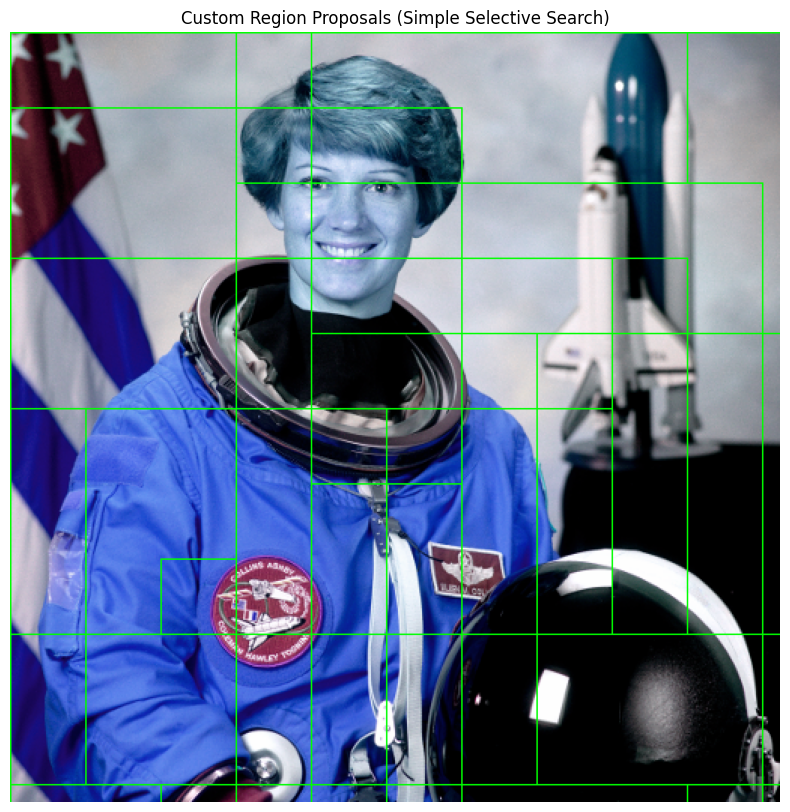

In [16]:
# Draw final proposed regions
output = img_rgb.copy()

for r in merged:
    x, y, w, h = r['rect']
    cv2.rectangle(output, (x, y), (x+w, y+h), (0, 255, 0), 1)

plt.figure(figsize=(10, 10))
plt.imshow(output)
plt.title("Custom Region Proposals (Simple Selective Search)")
plt.axis('off')
plt.show()
